# COMP90051 Assignment 2 Data Exploration

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [2]:
#setting working directory
import os
os.chdir('/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/Shoe vs Sandal vs Boot Dataset')
print(os.getcwd())

/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/Shoe vs Sandal vs Boot Dataset


In [3]:
#loading image paths
data_dir = Path('.')

boot_images = list((data_dir / 'Boot').glob('*.jpg')) + list((data_dir / 'Boot').glob('*.png'))
sandal_images = list((data_dir / 'Sandal').glob('*.jpg')) + list((data_dir / 'Sandal').glob('*.png'))
shoe_images = list((data_dir / 'Shoe').glob('*.jpg')) + list((data_dir / 'Shoe').glob('*.png'))

print(f"Boot: {len(boot_images)} images")
print(f"Sandal: {len(sandal_images)} images")
print(f"Shoe: {len(shoe_images)} images")
print(f"Total: {len(boot_images) + len(sandal_images) + len(shoe_images)} images")

Boot: 5000 images
Sandal: 5000 images
Shoe: 5000 images
Total: 15000 images


In [4]:
#combining image paths, creating labels
image_paths = boot_images + sandal_images + shoe_images
all_labels = ['Boot'] * len(boot_images) + ['Sandal'] * len(sandal_images) + ['Shoe'] * len(shoe_images)

Creating train/test split

In [5]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, 
    all_labels, 
    test_size = 0.2, 
    stratify = all_labels,
    random_state = 66
)

print(f"Training set: {len(train_paths)} images")
print(f"Test set: {len(test_paths)} images")

#checking class distribution (making sure train/test sets have the same proportion of each class)
from collections import Counter
print("\nTraining set distribution:", Counter(train_labels))
print("Test set distribution:", Counter(test_labels))

Training set: 12000 images
Test set: 3000 images

Training set distribution: Counter({'Boot': 4000, 'Sandal': 4000, 'Shoe': 4000})
Test set distribution: Counter({'Shoe': 1000, 'Sandal': 1000, 'Boot': 1000})


# Research Question

**"When trained on augmented data, which machine learning architectures are most robust to progressively severe real-world distortions in footwear classification?"**

We want to look at which architectures handle distortions/noise best, when given augmented training data. The approach is as follows
1. Apply moderate augmentation/distortions to the training set
2. Create 5 severity levels for each distortion type, for the test set
    * For example, our first test set will be clean. Second test set will have mild distortions,...,last test set will have extreme distortions
3. Train 3 models on augmented data
    * This phase will include CV/Hyperparameter tuning
4. Testing
    * Test each model on each of the 5 test sets, with the goal of exploring how model performance deviates, as the images that we feed in have increasing levels of distortion

An alternative approach, adds in the step of training another set of 3 models, on clean data only. This allows us to answer/investigate the following:
* Real world images are noisy. We want our models to be robust, even when trained on/tested on images that have natural distortions/occlusions. The question we want to answer is "is augmentation necessary for robustness". In other words, is it possible to train good robust models for image classification, when they are trained only on "clean" images? We would essentially be investigating this by training models on clean images, and seeing how they perform when they are given noisy/distorted images to classify. If these models still perform well, than we can say that certain model architectures are able to learn relevant features from clean images, and are not distracted by the added noise from the test images, when actually classifying unseen images.
Based on this, an alternative research question would be:

**"How does architectural choice affect robustness to real-world distortions: Is robustness inherent to the architecture or learned from augmented training?"**

In summary: 
* Condition A - Train on clean data -> Tests inherent robustness, which architectures naturally generalise
* Condition B - Train on augmented data -> Tests learned robustness, which architectures learn distortion-invariance explicitly, and are able to benefit most from being trained on augmented images, that are more similar (in that they have noise/occlusions/distortions) to real-world images that we wish to classify

## What distortions/occlusions/noise to add? 

Generally speaking, we have the following options, in regards to the types of distortions/occlusions/noise that we could add
* Rotation 
* Occlusion (blocking parts of the image)
* Noise/Background Clutter 
* Blur
* Brightness/Contrast changes
* Color Jitter
* Compression Artifacts

A realistic approach to adding distortions is as follows: The images that are currently in our dataset are very clean. More specifically, they depict footwear on a white background, with almost no noise. However, this is not a very realistic scenario. There may be many cases where we would want to classify footwear, where the images contains a lot of noise. Examples would be natural images of people wearing shoes. In these cases since we are only interested in classifying the footwear type, the other parts of the image (e.g. the background, what the individual is wearing, etc.) are all effectively noise. Hence, it makes sense to add noise to the images. 

Conversely, distortions such as progressively increasing the amount we rotate the images is not super realistic/useful. It is difficult to think of a scenario where we would want a model to accurately classify shoes that are upside down for example. Therefore, there is basis to ignore Rotations as a type of distortion to add to our images. 

Consider a E-Commerce "Visual Search" system, that has a "search by image" feature, where users upload images of shoes that they have taken themselves, and the system takes the image and classifies it.
The proposed 3 types of distortions that we will include are as follows:
1. Occlusion - The image uploaded by the user may have objects blocking parts of the shoe. For example, part of the shoe might be covered by a pant leg, in the image uploaded by the user.
2. Lighting - The lighting in which the image was taken will vary based on the user. For example, it is highly likely that we will get a big variation in the quality of lighting, for the images that are uploaded. 
3. Background Clutter - It is highly likely that the image taken will have a background that is noisy. For example, the background of the image might contain other objects. These all add noise to the images. Another way to think about it is that it is highly unlikely that the image uploaded by the user has a perfect 'white' background, with no noise/foreign objects. 

### Distortion 2 - Lighting

There are many options that we can consider when adding lighting distortions to our images. The following are ordered from simple to complex
* Basic Brightness Scaling 
    * Not very realistic, as realistic lighting distortions in real-world images are unlikely to be uniform. Also doesn't simulate shadows/highlights
* Contrast Adjustments 
    * Low contrast analogous to foggy conditions, whereas high contrast is harsh shadows, direct sunlight, dramatic lighting
* Gamma Correction
    * A more advanced version of brightness scaling, that affects shadows and highlights differently. More detail is preserved when darkening/brightening
* Exposure Simulation
* Shadows
    * Can add directional shadows, or random blob shadows
* Color Temperature
    * Adds simulation for indoor/outdoor lighting. For example, indoor lighting is likely to be warmer (more yellow), whereas outdoor lighting (natural daylight) is cooler (more blue)

#### Contrast Adjustment

In [ ]:
from PIL import ImageEnhance

def adjust_contrast(image_path, factor):
    """
    factor < 1.0: low contrast (flat, washed out)
    factor = 1.0: original
    factor > 1.0: high contrast (harsh lighting)
    """
    #load image
    img = Image.open(image_path)
    
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor)

In [31]:
original = Image.open(boot_images[0])
low_contrast = adjust_contrast(boot_images[0], 0.6)   # Diffuse/cloudy lighting
high_contrast = adjust_contrast(boot_images[0], 1.4)  # Harsh direct sunlight

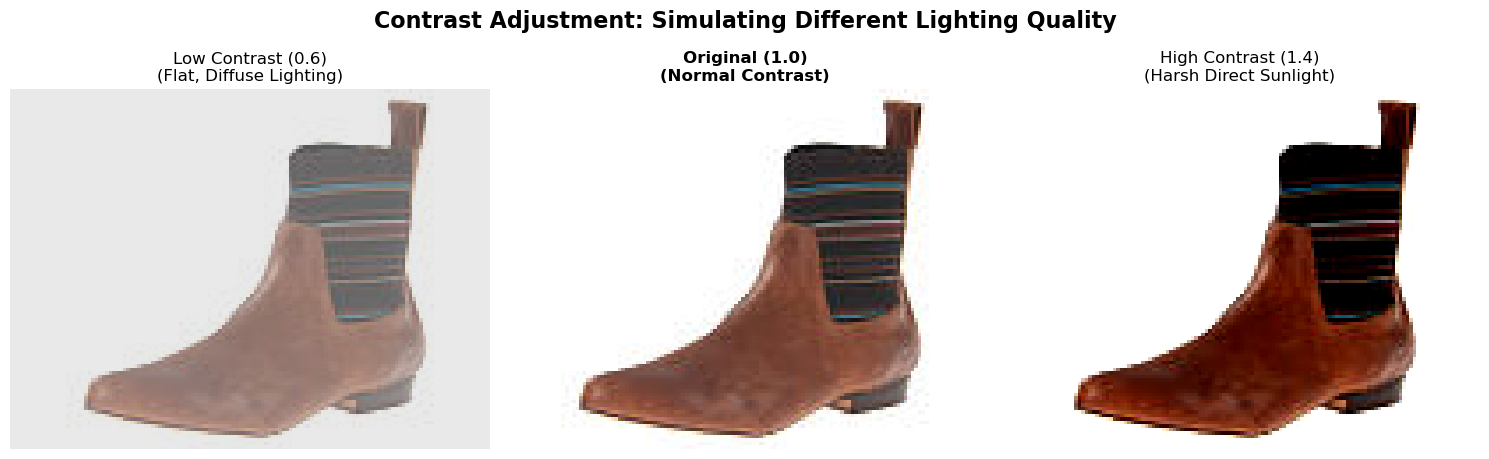

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(low_contrast)
axes[0].set_title('Low Contrast (0.6)\n(Flat, Diffuse Lighting)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(original)
axes[1].set_title('Original (1.0)\n(Normal Contrast)', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(high_contrast)
axes[2].set_title('High Contrast (1.4)\n(Harsh Direct Sunlight)', fontsize=12)
axes[2].axis('off')

plt.suptitle('Contrast Adjustment: Simulating Different Lighting Quality', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Gamma Correction - Advanced Brightness Scaling

In [15]:
def adjust_gamma(image_path, gamma=1.0):
    """
    gamma < 1.0: brighter (expands shadows)
    gamma = 1.0: original
    gamma > 1.0: darker (compresses highlights)
    
    More realistic than linear brightness adjustment
    """
    #load image
    img = Image.open(image_path)
    
    img_array = np.array(img).astype(float) / 255.0 # Normalize to [0, 1]
    
    #apply gamma correction
    corrected = np.power(img_array, gamma)
    
    #convert back to [0, 255]
    corrected = (corrected * 255).astype(np.uint8)
    
    return Image.fromarray(corrected)


In [ ]:
brighter = adjust_gamma(boot_images[0], gamma=0.7)  # Simulates better lighting
darker = adjust_gamma(boot_images[0], gamma=1.5)    # Simulates dim lighting

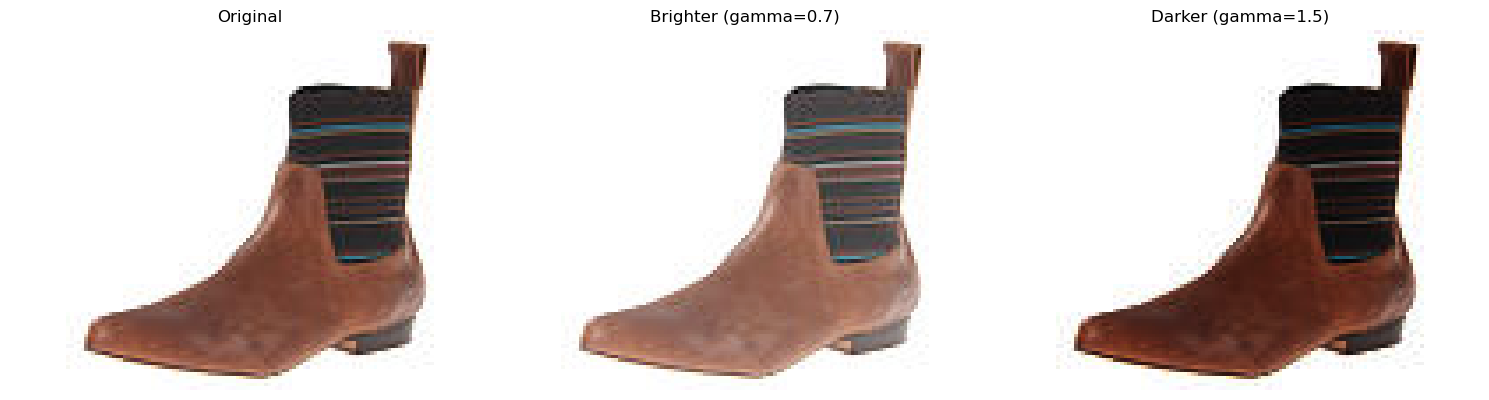

In [17]:
#display them
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Load original for display
original = Image.open(boot_images[0])

axes[0].imshow(original)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(brighter)
axes[1].set_title('Brighter (gamma=0.7)')
axes[1].axis('off')

axes[2].imshow(darker)
axes[2].set_title('Darker (gamma=1.5)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

#### Exposure Simulation

In [ ]:
def simulate_exposure(image_path, exposure_compensation):
    """
    Simulate camera exposure compensation (EV)
    exposure_compensation in range [-3, +3]
    
    Negative: underexposed (too dark)
    Positive: overexposed (too bright)
    """
    #load image
    img = Image.open(image_path)
    
    img_array = np.array(img).astype(float) / 255.0
    
    # Each EV stop doubles or halves the light
    exposure_factor = 2 ** exposure_compensation
    
    # Apply exposure
    exposed = img_array * exposure_factor
    
    # Clip to valid range (simulates clipping in camera)
    exposed = np.clip(exposed, 0, 1)
    
    # Convert back
    exposed = (exposed * 255).astype(np.uint8)
    
    return Image.fromarray(exposed)

In [20]:
underexposed_2stops = simulate_exposure(boot_images[0], -2)  # Very dark
underexposed_1stop = simulate_exposure(boot_images[0], -1)   # Somewhat dark
original = Image.open(boot_images[0])                        # Original
overexposed_1stop = simulate_exposure(boot_images[0], +1)    # Somewhat bright
overexposed_2stops = simulate_exposure(boot_images[0], +2)   # Washed out

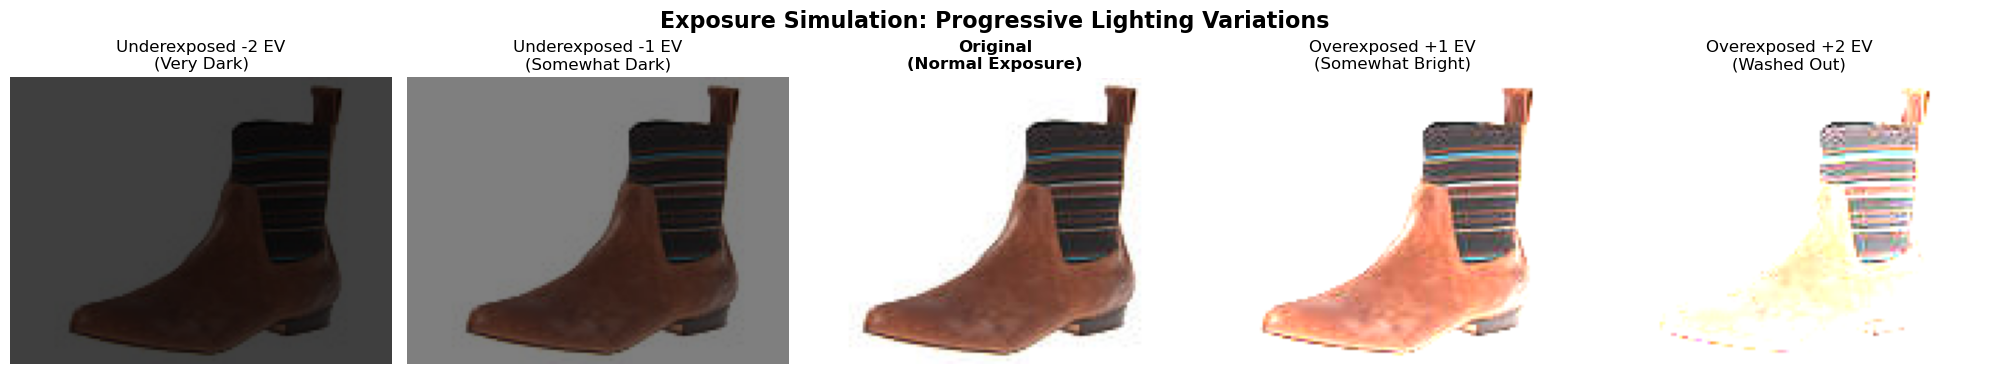

In [21]:
# Display them
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(underexposed_2stops)
axes[0].set_title('Underexposed -2 EV\n(Very Dark)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(underexposed_1stop)
axes[1].set_title('Underexposed -1 EV\n(Somewhat Dark)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(original)
axes[2].set_title('Original\n(Normal Exposure)', fontsize=12, fontweight='bold')
axes[2].axis('off')

axes[3].imshow(overexposed_1stop)
axes[3].set_title('Overexposed +1 EV\n(Somewhat Bright)', fontsize=12)
axes[3].axis('off')

axes[4].imshow(overexposed_2stops)
axes[4].set_title('Overexposed +2 EV\n(Washed Out)', fontsize=12)
axes[4].axis('off')

plt.suptitle('Exposure Simulation: Progressive Lighting Variations', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Shadows

In [23]:
from scipy.ndimage import gaussian_filter

def add_random_shadow(image_path, num_shadows=2, intensity=0.4):
    """
    Add random blob-like shadows (simulate objects casting shadows)
    """
    #load image
    img = Image.open(image_path)
    
    img_array = np.array(img).astype(float)
    height, width = img_array.shape[:2]
    
    # Create shadow mask
    shadow_mask = np.ones((height, width))
    
    for _ in range(num_shadows):
        # Random shadow region
        center_x = np.random.randint(0, width)
        center_y = np.random.randint(0, height)
        radius = np.random.randint(50, 150)
        
        # Create circular shadow
        y, x = np.ogrid[:height, :width]
        mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
        
        # Blur edges for smooth transition
        shadow_blob = gaussian_filter(mask.astype(float), sigma=30)
        
        # Add to shadow mask
        shadow_mask -= shadow_blob * intensity
    
    shadow_mask = np.clip(shadow_mask, 0, 1)
    
    # Apply shadows
    shadowed = img_array * shadow_mask[:, :, np.newaxis]
    shadowed = np.clip(shadowed, 0, 255).astype(np.uint8)
    
    return Image.fromarray(shadowed)

In [24]:
original = Image.open(boot_images[0])
shadow_light = add_random_shadow(boot_images[0], num_shadows=1, intensity=0.2)
shadow_moderate = add_random_shadow(boot_images[0], num_shadows=2, intensity=0.4)
shadow_heavy = add_random_shadow(boot_images[0], num_shadows=3, intensity=0.6)
shadow_extreme = add_random_shadow(boot_images[0], num_shadows=4, intensity=0.7)

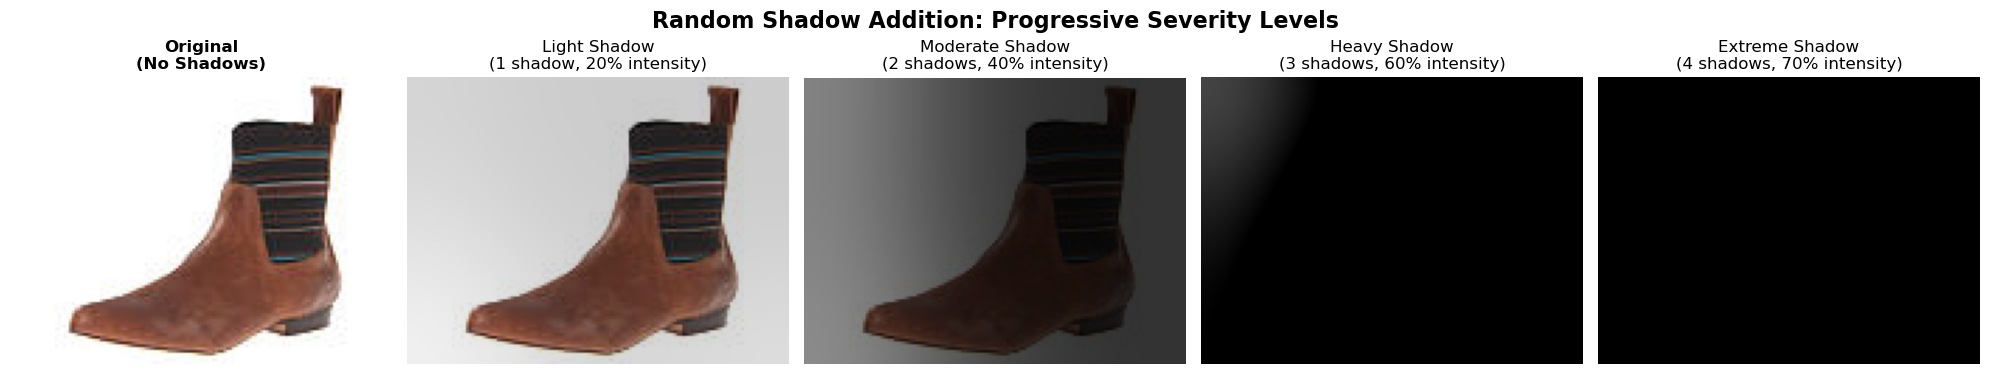

In [25]:
# Display comparison
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(original)
axes[0].set_title('Original\n(No Shadows)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(shadow_light)
axes[1].set_title('Light Shadow\n(1 shadow, 20% intensity)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(shadow_moderate)
axes[2].set_title('Moderate Shadow\n(2 shadows, 40% intensity)', fontsize=12)
axes[2].axis('off')

axes[3].imshow(shadow_heavy)
axes[3].set_title('Heavy Shadow\n(3 shadows, 60% intensity)', fontsize=12)
axes[3].axis('off')

axes[4].imshow(shadow_extreme)
axes[4].set_title('Extreme Shadow\n(4 shadows, 70% intensity)', fontsize=12)
axes[4].axis('off')

plt.suptitle('Random Shadow Addition: Progressive Severity Levels', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Colour Temperature

In [26]:
def adjust_color_temperature(image_path, temperature):
    """
    Adjust color temperature to simulate different light sources
    
    temperature < 0: cooler (blue-ish, outdoor/overcast)
    temperature = 0: neutral
    temperature > 0: warmer (yellow/orange, indoor/sunset)
    
    Range: -50 to +50
    """
    #load image
    img = Image.open(image_path)
    
    img_array = np.array(img).astype(float)
    
    if temperature > 0:  # Warmer
        # Add red/yellow
        img_array[:, :, 0] += temperature  # Red channel
        img_array[:, :, 1] += temperature * 0.5  # Green channel
    else:  # Cooler
        # Add blue
        img_array[:, :, 2] -= temperature  # Blue channel
    
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    
    return Image.fromarray(img_array)

In [27]:
# Examples:
indoor_warm = adjust_color_temperature(boot_images[0], +30)    # Incandescent bulbs
outdoor_cool = adjust_color_temperature(boot_images[0], -20)   # Overcast day
sunset = adjust_color_temperature(boot_images[0], +50)         # Golden hour

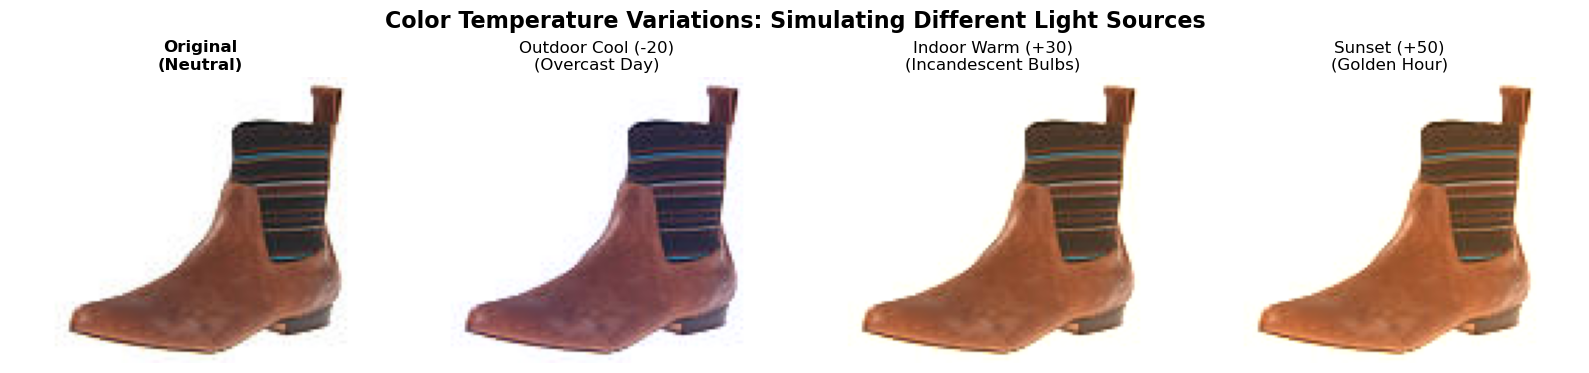

In [28]:
# Display comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(original)
axes[0].set_title('Original\n(Neutral)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(outdoor_cool)
axes[1].set_title('Outdoor Cool (-20)\n(Overcast Day)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(indoor_warm)
axes[2].set_title('Indoor Warm (+30)\n(Incandescent Bulbs)', fontsize=12)
axes[2].axis('off')

axes[3].imshow(sunset)
axes[3].set_title('Sunset (+50)\n(Golden Hour)', fontsize=12)
axes[3].axis('off')

plt.suptitle('Color Temperature Variations: Simulating Different Light Sources', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()